In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rc('font', **{'size': 20})

In [6]:
def add_day_columns(df, timestamp_col, participant_df):
    return add_rel_day(add_start_day(add_day(df, timestamp_col), participant_df))

def add_day(df, timestamp_col):
    df = df.copy()
    df["Day"] = (df[timestamp_col]/(60*60*24)).apply(np.floor)
    return df

def add_start_day(df, participant_df):
    participant_df = participant_df.copy()
    participant_df["StartDay"] = (participant_df["DataStartStamp"]/(60*60*24)).apply(np.floor)
    return pd.merge(df, participant_df[['ParticipantId',"StartDay"]])

def add_rel_day(df):
    df = df.copy()
    df["RelDay"] = df["Day"]-df["StartDay"]
    return df

def scale(df, group_col, scale_col, scaler, postfix):
    for gid in set(df[group_col]):
        df.loc[df[group_col]==gid,[scale_col+postfix]] = scaler.fit_transform(df.loc[df[group_col]==gid,[scale_col]])

def get_trimmed_pids(df):
    df = df.copy()
    df = df[~df["Phone ER Interest"].isna()]
    df = df.groupby(["ParticipantId","RelDay"]).size().reset_index(drop=False)
    df = df.groupby(['ParticipantId']).size().reset_index(drop=False).rename(columns={0:"Count"})
    return df.loc[df.Count < 4,'ParticipantId'].tolist()

def sample_and_mean(x):
    return lambda g: g.mean() if g.shape[0] < x else g.sample(x).mean()

def largest_and_mean(x):
    return lambda g: g.nlargest(x).mean()

def smallest_and_mean(x):
    return lambda g: g.nsmallest(x).mean()

In [ ]:
emotions_df = pd.read_csv('../data/Emotions.csv')
participant_df = pd.read_csv('../data/Participants.csv')

emotions_df = emotions_df[emotions_df["WatchDataQuality"] == "Good"]

emotions_df["ER Interest"] = pd.to_numeric(emotions_df["ER Interest"], errors='coerce')
emotions_df["Phone ER Interest"] = pd.to_numeric(emotions_df["Phone ER Interest"], errors='coerce')
emotions_df["Response Time (min)"] = (emotions_df["SubmissionTimestamp"] - emotions_df["DeliveredTimestamp"])/60

emotions_df = add_day_columns(emotions_df, "OpenedTimestamp", participant_df)

to_trim = get_trimmed_pids(emotions_df)

emotions_df = emotions_df[~emotions_df["ParticipantId"].isin(to_trim)]
emotions_df = emotions_df[emotions_df["RelDay"] < 11]

emotions_df.shape

(3650, 22)

# Moderate Turnover In All 1s

The number of participants who report all 1 is about half as big as the total number of participants who report all 1. This suggests that half of the all 1 reporters change each day.

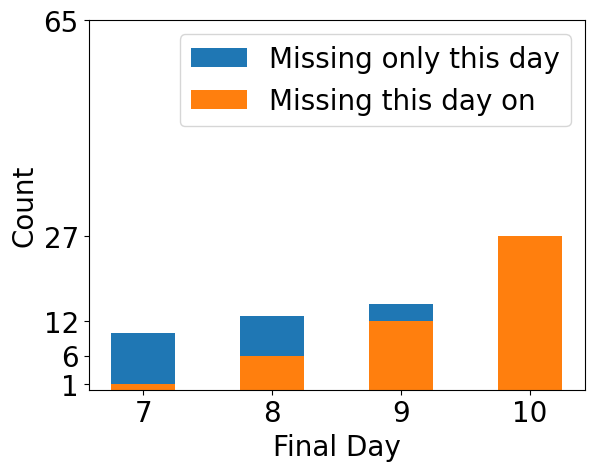

In [10]:
def local():
    df = emotions_df.copy()
    df = df[df["State Anxiety"]!= 1]
    
    counts1 = df.groupby("ParticipantId")["RelDay"].max().value_counts()
    counts2 = df.drop_duplicates(["RelDay","ParticipantId"])["RelDay"].value_counts()
    X  = [7,8,9,10]
    Y1 = [counts1[x-1] for x in X]
    Y2 = [65-counts2[x] for x in X]
    
    plt.bar(X, Y2, width=.5, label="Missing only this day")
    plt.bar(X, np.cumsum(Y1), width=.5, label="Missing this day on")
    #plt.bar([6.25, 8.25, 10.25, 12.25], Y2, width=.5, label="Missing on this day")
    plt.yticks([1,6,12,27,65])
    plt.legend()
    plt.ylabel("Count")
    plt.xlabel("Final Day")

    return 
local()

In [11]:
def local():
    df = emotions_df.copy()
    df = df[df["State Anxiety"]!= 1]
    
    df = df.groupby("ParticipantId")["RelDay"].max().reset_index()

    df = df.rename(columns={"RelDay":"Last Day With Anxiety > 1"})

    return df[df["Last Day With Anxiety > 1"] <= 8 ]
local()


,ParticipantId,Last Day With Anxiety > 1
8,423,8.0
11,430,7.0
14,433,8.0
17,437,8.0
20,441,7.0
21,442,8.0
24,445,7.0
25,446,8.0
35,458,7.0
45,471,6.0


In [12]:
def local():
    drop = emotions_df.copy()
    keep = emotions_df.copy()
    
    drop = drop[drop["State Anxiety"]!= 1]
    drop = drop.groupby("ParticipantId")["RelDay"].max().reset_index()
    drop = drop.rename(columns={"RelDay":"Last Day With Anxiety > 1"})
    drop = drop[drop["Last Day With Anxiety > 1"] <= 8 ]

    for pid,day in drop.itertuples(index=False):
        is_not_pid = keep["ParticipantId"] != pid
        is_lt_day  = keep["RelDay"] < day
        keep = keep[is_not_pid | is_lt_day]

    return keep

keep_df = local()

dropped_rows = emotions_df.shape[0]-keep_df.shape[0]
print(f"Dropped {dropped_rows} rows")


Dropped 170 rows
